## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [8]:
import itertools
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 185us/step - loss: 198.7601 - acc: 0.2321 - val_loss: 41.1498 - val_acc: 0.2404
Epoch 2/50
50000/50000 [==============================] - 9s 171us/step - loss: 19.1148 - acc: 0.1164 - val_loss: 7.2720 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 9s 171us/step - loss: 4.1004 - acc: 0.0998 - val_loss: 2.6443 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 8s 167us/step - loss: 2.4858 - acc: 0.0965 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - acc: 0.0966 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 170us/step - loss: 2.4626 - acc: 0.0973 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.462

Epoch 2/50
50000/50000 [==============================] - 8s 167us/step - loss: 19.0775 - acc: 0.1186 - val_loss: 7.2610 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 9s 172us/step - loss: 4.0917 - acc: 0.0975 - val_loss: 2.6426 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 9s 173us/step - loss: 2.4857 - acc: 0.0973 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.4626 - acc: 0.0982 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 9s 174us/step - loss: 2.4626 - acc: 0.0979 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 9s 175us/step - loss: 2.4626 - acc: 0.0992 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 9s 180us/step - loss: 2.4626 - acc: 0.0973 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 9/50
50000/50000 [=========

50000/50000 [==============================] - 8s 164us/step - loss: 4.1055 - acc: 0.1000 - val_loss: 2.6446 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.4856 - acc: 0.0970 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.4626 - acc: 0.0981 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.4626 - acc: 0.0967 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 8s 164us/step - loss: 2.4626 - acc: 0.0986 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 8s 170us/step - loss: 2.4626 - acc: 0.0965 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.4626 - acc: 0.0994 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 10/50
50000/50000 [====================

50000/50000 [==============================] - 8s 150us/step - loss: 2.4857 - acc: 0.0974 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.4626 - acc: 0.0973 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.4626 - acc: 0.0977 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 8s 150us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 8s 150us/step - loss: 2.4626 - acc: 0.0994 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 8s 153us/step - loss: 2.4626 - acc: 0.0976 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.4626 - acc: 0.0990 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 11/50
50000/50000 [===================

50000/50000 [==============================] - 9s 172us/step - loss: 10.5455 - acc: 0.4070 - val_loss: 9.8359 - val_acc: 0.4053
Epoch 6/50
50000/50000 [==============================] - 9s 179us/step - loss: 9.2060 - acc: 0.4148 - val_loss: 8.6028 - val_acc: 0.4145
Epoch 7/50
50000/50000 [==============================] - 9s 179us/step - loss: 8.0658 - acc: 0.4204 - val_loss: 7.5549 - val_acc: 0.4208
Epoch 8/50
50000/50000 [==============================] - 9s 180us/step - loss: 7.0939 - acc: 0.4248 - val_loss: 6.6563 - val_acc: 0.4249
Epoch 9/50
50000/50000 [==============================] - 9s 172us/step - loss: 6.2678 - acc: 0.4293 - val_loss: 5.8958 - val_acc: 0.4307
Epoch 10/50
50000/50000 [==============================] - 8s 168us/step - loss: 5.5629 - acc: 0.4324 - val_loss: 5.2449 - val_acc: 0.4319
Epoch 11/50
50000/50000 [==============================] - 8s 165us/step - loss: 4.9627 - acc: 0.4378 - val_loss: 4.6924 - val_acc: 0.4378
Epoch 12/50
50000/50000 [=================

50000/50000 [==============================] - 8s 169us/step - loss: 5.3595 - acc: 0.4403 - val_loss: 5.3333 - val_acc: 0.4322
Epoch 7/50
50000/50000 [==============================] - 8s 167us/step - loss: 5.2587 - acc: 0.4527 - val_loss: 5.2279 - val_acc: 0.4510
Epoch 8/50
50000/50000 [==============================] - 9s 171us/step - loss: 5.1620 - acc: 0.4637 - val_loss: 5.1327 - val_acc: 0.4583
Epoch 9/50
50000/50000 [==============================] - 8s 167us/step - loss: 5.0704 - acc: 0.4720 - val_loss: 5.0473 - val_acc: 0.4642
Epoch 10/50
50000/50000 [==============================] - 9s 171us/step - loss: 4.9819 - acc: 0.4805 - val_loss: 4.9655 - val_acc: 0.4684
Epoch 11/50
50000/50000 [==============================] - 8s 169us/step - loss: 4.8936 - acc: 0.4890 - val_loss: 4.8970 - val_acc: 0.4721
Epoch 12/50
50000/50000 [==============================] - 9s 174us/step - loss: 4.8105 - acc: 0.4957 - val_loss: 4.8368 - val_acc: 0.4694
Epoch 13/50
50000/50000 [=================

50000/50000 [==============================] - 8s 166us/step - loss: 5.1570 - acc: 0.4540 - val_loss: 5.1350 - val_acc: 0.4390
Epoch 8/50
50000/50000 [==============================] - 9s 173us/step - loss: 5.0652 - acc: 0.4634 - val_loss: 5.0422 - val_acc: 0.4564
Epoch 9/50
50000/50000 [==============================] - 8s 169us/step - loss: 4.9779 - acc: 0.4730 - val_loss: 4.9678 - val_acc: 0.4594
Epoch 10/50
50000/50000 [==============================] - 9s 173us/step - loss: 4.8931 - acc: 0.4806 - val_loss: 4.8916 - val_acc: 0.4672
Epoch 11/50
50000/50000 [==============================] - 8s 168us/step - loss: 4.8095 - acc: 0.4868 - val_loss: 4.8264 - val_acc: 0.4665
Epoch 12/50
50000/50000 [==============================] - 9s 173us/step - loss: 4.7310 - acc: 0.4944 - val_loss: 4.7260 - val_acc: 0.4793
Epoch 13/50
50000/50000 [==============================] - 8s 169us/step - loss: 4.6527 - acc: 0.5013 - val_loss: 4.6643 - val_acc: 0.4835
Epoch 14/50
50000/50000 [================

50000/50000 [==============================] - 8s 167us/step - loss: 5.0590 - acc: 0.4641 - val_loss: 5.0366 - val_acc: 0.4573
Epoch 9/50
50000/50000 [==============================] - 8s 164us/step - loss: 4.9721 - acc: 0.4724 - val_loss: 4.9588 - val_acc: 0.4637
Epoch 10/50
50000/50000 [==============================] - 8s 167us/step - loss: 4.8863 - acc: 0.4805 - val_loss: 4.8745 - val_acc: 0.4715
Epoch 11/50
50000/50000 [==============================] - 8s 165us/step - loss: 4.8063 - acc: 0.4872 - val_loss: 4.8052 - val_acc: 0.4691
Epoch 12/50
50000/50000 [==============================] - 8s 168us/step - loss: 4.7250 - acc: 0.4962 - val_loss: 4.7439 - val_acc: 0.4702
Epoch 13/50
50000/50000 [==============================] - 8s 164us/step - loss: 4.6491 - acc: 0.5032 - val_loss: 4.6537 - val_acc: 0.4830
Epoch 14/50
50000/50000 [==============================] - 8s 169us/step - loss: 4.5709 - acc: 0.5081 - val_loss: 4.5765 - val_acc: 0.4934
Epoch 15/50
50000/50000 [===============

50000/50000 [==============================] - 7s 148us/step - loss: 4.9641 - acc: 0.4789 - val_loss: 4.9494 - val_acc: 0.4673
Epoch 10/50
50000/50000 [==============================] - 7s 144us/step - loss: 4.8818 - acc: 0.4853 - val_loss: 4.8705 - val_acc: 0.4772
Epoch 11/50
50000/50000 [==============================] - 7s 148us/step - loss: 4.8008 - acc: 0.4932 - val_loss: 4.8066 - val_acc: 0.4740
Epoch 12/50
50000/50000 [==============================] - 7s 144us/step - loss: 4.7219 - acc: 0.4991 - val_loss: 4.7371 - val_acc: 0.4808
Epoch 13/50
50000/50000 [==============================] - 7s 145us/step - loss: 4.6458 - acc: 0.5052 - val_loss: 4.6639 - val_acc: 0.4861
Epoch 14/50
50000/50000 [==============================] - 7s 145us/step - loss: 4.5689 - acc: 0.5108 - val_loss: 4.5884 - val_acc: 0.4909
Epoch 15/50
50000/50000 [==============================] - 7s 145us/step - loss: 4.4949 - acc: 0.5180 - val_loss: 4.5225 - val_acc: 0.4908
Epoch 16/50
50000/50000 [==============

50000/50000 [==============================] - 9s 174us/step - loss: 4.9107 - acc: 0.4375 - val_loss: 4.6734 - val_acc: 0.4303
Epoch 11/50
50000/50000 [==============================] - 8s 169us/step - loss: 4.4464 - acc: 0.4438 - val_loss: 4.2419 - val_acc: 0.4464
Epoch 12/50
50000/50000 [==============================] - 9s 177us/step - loss: 4.0490 - acc: 0.4469 - val_loss: 3.8719 - val_acc: 0.4482
Epoch 13/50
50000/50000 [==============================] - 8s 168us/step - loss: 3.7076 - acc: 0.4521 - val_loss: 3.5712 - val_acc: 0.4506
Epoch 14/50
50000/50000 [==============================] - 9s 173us/step - loss: 3.4167 - acc: 0.4562 - val_loss: 3.2962 - val_acc: 0.4482
Epoch 15/50
50000/50000 [==============================] - 9s 172us/step - loss: 3.1663 - acc: 0.4591 - val_loss: 3.0630 - val_acc: 0.4566
Epoch 16/50
50000/50000 [==============================] - 8s 168us/step - loss: 2.9523 - acc: 0.4613 - val_loss: 2.8631 - val_acc: 0.4598
Epoch 17/50
50000/50000 [==============

50000/50000 [==============================] - 8s 167us/step - loss: 1.5755 - acc: 0.4947 - val_loss: 1.6013 - val_acc: 0.4818
Epoch 12/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.5526 - acc: 0.5032 - val_loss: 1.6028 - val_acc: 0.4787
Epoch 13/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.5321 - acc: 0.5115 - val_loss: 1.6006 - val_acc: 0.4818
Epoch 14/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.5119 - acc: 0.5173 - val_loss: 1.5736 - val_acc: 0.4941
Epoch 15/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.4921 - acc: 0.5244 - val_loss: 1.5678 - val_acc: 0.4912
Epoch 16/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.4741 - acc: 0.5303 - val_loss: 1.5642 - val_acc: 0.5008
Epoch 17/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.4567 - acc: 0.5377 - val_loss: 1.5482 - val_acc: 0.5011
Epoch 18/50
50000/50000 [==============

50000/50000 [==============================] - 8s 167us/step - loss: 1.4124 - acc: 0.5060 - val_loss: 1.4641 - val_acc: 0.4804
Epoch 13/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.3928 - acc: 0.5115 - val_loss: 1.4502 - val_acc: 0.4861
Epoch 14/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.3694 - acc: 0.5186 - val_loss: 1.4819 - val_acc: 0.4695
Epoch 15/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.3525 - acc: 0.5257 - val_loss: 1.4172 - val_acc: 0.4951
Epoch 16/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.3330 - acc: 0.5321 - val_loss: 1.4151 - val_acc: 0.4981
Epoch 17/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.3152 - acc: 0.5377 - val_loss: 1.4037 - val_acc: 0.5050
Epoch 18/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.2965 - acc: 0.5434 - val_loss: 1.4226 - val_acc: 0.4933
Epoch 19/50
50000/50000 [==============

50000/50000 [==============================] - 8s 164us/step - loss: 1.4033 - acc: 0.5090 - val_loss: 1.4484 - val_acc: 0.4831
Epoch 14/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.3815 - acc: 0.5151 - val_loss: 1.4442 - val_acc: 0.4921
Epoch 15/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.3606 - acc: 0.5228 - val_loss: 1.4183 - val_acc: 0.4937
Epoch 16/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.3428 - acc: 0.5293 - val_loss: 1.4239 - val_acc: 0.4925
Epoch 17/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.3228 - acc: 0.5378 - val_loss: 1.3990 - val_acc: 0.5036
Epoch 18/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.3063 - acc: 0.5426 - val_loss: 1.3786 - val_acc: 0.5113
Epoch 19/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.2893 - acc: 0.5474 - val_loss: 1.3825 - val_acc: 0.5090
Epoch 20/50
50000/50000 [==============

50000/50000 [==============================] - 7s 147us/step - loss: 1.3734 - acc: 0.5161 - val_loss: 1.4248 - val_acc: 0.4964
Epoch 15/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.3530 - acc: 0.5236 - val_loss: 1.4495 - val_acc: 0.4923
Epoch 16/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.3352 - acc: 0.5318 - val_loss: 1.4241 - val_acc: 0.4983
Epoch 17/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.3157 - acc: 0.5371 - val_loss: 1.4255 - val_acc: 0.4962
Epoch 18/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.2979 - acc: 0.5469 - val_loss: 1.3930 - val_acc: 0.5095
Epoch 19/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.2813 - acc: 0.5494 - val_loss: 1.4151 - val_acc: 0.4981
Epoch 20/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.2662 - acc: 0.5554 - val_loss: 1.4203 - val_acc: 0.4985
Epoch 21/50
50000/50000 [==============

50000/50000 [==============================] - 8s 168us/step - loss: 3.1690 - acc: 0.4564 - val_loss: 3.0679 - val_acc: 0.4519
Epoch 16/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.9528 - acc: 0.4619 - val_loss: 2.8680 - val_acc: 0.4623
Epoch 17/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.7695 - acc: 0.4642 - val_loss: 2.6984 - val_acc: 0.4594
Epoch 18/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.6129 - acc: 0.4675 - val_loss: 2.5665 - val_acc: 0.4511
Epoch 19/50
50000/50000 [==============================] - 9s 170us/step - loss: 2.4764 - acc: 0.4721 - val_loss: 2.4286 - val_acc: 0.4621
Epoch 20/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.3605 - acc: 0.4733 - val_loss: 2.3323 - val_acc: 0.4595
Epoch 21/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.2611 - acc: 0.4763 - val_loss: 2.2562 - val_acc: 0.4589
Epoch 22/50
50000/50000 [==============

50000/50000 [==============================] - 8s 163us/step - loss: 1.4778 - acc: 0.5301 - val_loss: 1.5437 - val_acc: 0.5053
Epoch 17/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.4601 - acc: 0.5370 - val_loss: 1.5504 - val_acc: 0.5036
Epoch 18/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.4427 - acc: 0.5428 - val_loss: 1.5961 - val_acc: 0.4903
Epoch 19/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.4282 - acc: 0.5454 - val_loss: 1.5271 - val_acc: 0.5138
Epoch 20/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4122 - acc: 0.5520 - val_loss: 1.5306 - val_acc: 0.5007
Epoch 21/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.3948 - acc: 0.5612 - val_loss: 1.5284 - val_acc: 0.5083
Epoch 22/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.3804 - acc: 0.5641 - val_loss: 1.4956 - val_acc: 0.5178
Epoch 23/50
50000/50000 [==============

50000/50000 [==============================] - 8s 162us/step - loss: 1.3171 - acc: 0.5344 - val_loss: 1.4019 - val_acc: 0.5023
Epoch 18/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.3000 - acc: 0.5418 - val_loss: 1.4026 - val_acc: 0.4979
Epoch 19/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.2811 - acc: 0.5492 - val_loss: 1.3693 - val_acc: 0.5142
Epoch 20/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.2657 - acc: 0.5547 - val_loss: 1.3801 - val_acc: 0.5122
Epoch 21/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.2519 - acc: 0.5585 - val_loss: 1.3601 - val_acc: 0.5180
Epoch 22/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.2357 - acc: 0.5639 - val_loss: 1.3754 - val_acc: 0.5119
Epoch 23/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.2234 - acc: 0.5682 - val_loss: 1.3805 - val_acc: 0.5106
Epoch 24/50
50000/50000 [==============

50000/50000 [==============================] - 9s 176us/step - loss: 1.3099 - acc: 0.5397 - val_loss: 1.4057 - val_acc: 0.5005
Epoch 19/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.2940 - acc: 0.5461 - val_loss: 1.4003 - val_acc: 0.5032
Epoch 20/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.2769 - acc: 0.5530 - val_loss: 1.4077 - val_acc: 0.4959
Epoch 21/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.2637 - acc: 0.5558 - val_loss: 1.3837 - val_acc: 0.5037
Epoch 22/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.2472 - acc: 0.5624 - val_loss: 1.3673 - val_acc: 0.5126
Epoch 23/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.2321 - acc: 0.5679 - val_loss: 1.3578 - val_acc: 0.5188
Epoch 24/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.2161 - acc: 0.5721 - val_loss: 1.3906 - val_acc: 0.5067
Epoch 25/50
50000/50000 [==============

50000/50000 [==============================] - 7s 145us/step - loss: 1.2973 - acc: 0.5424 - val_loss: 1.4719 - val_acc: 0.4771
Epoch 20/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.2794 - acc: 0.5512 - val_loss: 1.3984 - val_acc: 0.5049
Epoch 21/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.2619 - acc: 0.5572 - val_loss: 1.4019 - val_acc: 0.5061
Epoch 22/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.2473 - acc: 0.5628 - val_loss: 1.3780 - val_acc: 0.5155
Epoch 23/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.2328 - acc: 0.5667 - val_loss: 1.3887 - val_acc: 0.5057
Epoch 24/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.2183 - acc: 0.5724 - val_loss: 1.3763 - val_acc: 0.5174
Epoch 25/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.2026 - acc: 0.5778 - val_loss: 1.3686 - val_acc: 0.5165
Epoch 26/50
50000/50000 [==============

50000/50000 [==============================] - 7s 140us/step - loss: 2.3665 - acc: 0.4718 - val_loss: 2.3234 - val_acc: 0.4674
Epoch 21/50
50000/50000 [==============================] - 7s 141us/step - loss: 2.2654 - acc: 0.4738 - val_loss: 2.2411 - val_acc: 0.4666
Epoch 22/50
50000/50000 [==============================] - 7s 139us/step - loss: 2.1796 - acc: 0.4775 - val_loss: 2.1530 - val_acc: 0.4712
Epoch 23/50
50000/50000 [==============================] - 7s 142us/step - loss: 2.1062 - acc: 0.4789 - val_loss: 2.1097 - val_acc: 0.4513
Epoch 24/50
50000/50000 [==============================] - 7s 139us/step - loss: 2.0423 - acc: 0.4797 - val_loss: 2.0439 - val_acc: 0.4691
Epoch 25/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.9863 - acc: 0.4846 - val_loss: 1.9934 - val_acc: 0.4751
Epoch 26/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.9378 - acc: 0.4870 - val_loss: 1.9379 - val_acc: 0.4758
Epoch 27/50
50000/50000 [==============

50000/50000 [==============================] - 7s 147us/step - loss: 1.3849 - acc: 0.5619 - val_loss: 1.5229 - val_acc: 0.5045
Epoch 22/50
50000/50000 [==============================] - 8s 150us/step - loss: 1.3712 - acc: 0.5661 - val_loss: 1.5110 - val_acc: 0.5145
Epoch 23/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.3567 - acc: 0.5730 - val_loss: 1.4970 - val_acc: 0.5143
Epoch 24/50
50000/50000 [==============================] - 8s 150us/step - loss: 1.3421 - acc: 0.5772 - val_loss: 1.5106 - val_acc: 0.5168
Epoch 25/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.3266 - acc: 0.5852 - val_loss: 1.5140 - val_acc: 0.5126
Epoch 26/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.3146 - acc: 0.5874 - val_loss: 1.4871 - val_acc: 0.5234
Epoch 27/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.2993 - acc: 0.5923 - val_loss: 1.5343 - val_acc: 0.5114
Epoch 28/50
50000/50000 [==============

50000/50000 [==============================] - 7s 143us/step - loss: 1.2280 - acc: 0.5670 - val_loss: 1.3749 - val_acc: 0.5118
Epoch 23/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.2130 - acc: 0.5717 - val_loss: 1.4093 - val_acc: 0.5021
Epoch 24/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.2002 - acc: 0.5773 - val_loss: 1.3973 - val_acc: 0.5086
Epoch 25/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.1852 - acc: 0.5828 - val_loss: 1.3535 - val_acc: 0.5226
Epoch 26/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.1742 - acc: 0.5867 - val_loss: 1.3598 - val_acc: 0.5236
Epoch 27/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.1592 - acc: 0.5920 - val_loss: 1.3439 - val_acc: 0.5239
Epoch 28/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.1439 - acc: 0.5974 - val_loss: 1.3543 - val_acc: 0.5233
Epoch 29/50
50000/50000 [==============

50000/50000 [==============================] - 7s 143us/step - loss: 1.2319 - acc: 0.5668 - val_loss: 1.3607 - val_acc: 0.5145
Epoch 24/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.2163 - acc: 0.5721 - val_loss: 1.3608 - val_acc: 0.5165
Epoch 25/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.2001 - acc: 0.5787 - val_loss: 1.3781 - val_acc: 0.5052
Epoch 26/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.1855 - acc: 0.5843 - val_loss: 1.3418 - val_acc: 0.5260
Epoch 27/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.1701 - acc: 0.5886 - val_loss: 1.3668 - val_acc: 0.5145
Epoch 28/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.1565 - acc: 0.5936 - val_loss: 1.3402 - val_acc: 0.5287
Epoch 29/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.1462 - acc: 0.5962 - val_loss: 1.3593 - val_acc: 0.5160
Epoch 30/50
50000/50000 [==============

50000/50000 [==============================] - 6s 120us/step - loss: 1.1981 - acc: 0.5789 - val_loss: 1.3532 - val_acc: 0.5186
Epoch 25/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.1836 - acc: 0.5830 - val_loss: 1.3529 - val_acc: 0.5199
Epoch 26/50
50000/50000 [==============================] - 6s 116us/step - loss: 1.1702 - acc: 0.5878 - val_loss: 1.3676 - val_acc: 0.5121
Epoch 27/50
50000/50000 [==============================] - 6s 110us/step - loss: 1.1577 - acc: 0.5919 - val_loss: 1.3688 - val_acc: 0.5174
Epoch 28/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.1454 - acc: 0.5963 - val_loss: 1.3552 - val_acc: 0.5189
Epoch 29/50
50000/50000 [==============================] - 6s 116us/step - loss: 1.1315 - acc: 0.6021 - val_loss: 1.3399 - val_acc: 0.5267
Epoch 30/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.1166 - acc: 0.6076 - val_loss: 1.3720 - val_acc: 0.5172
Epoch 31/50
50000/50000 [==============

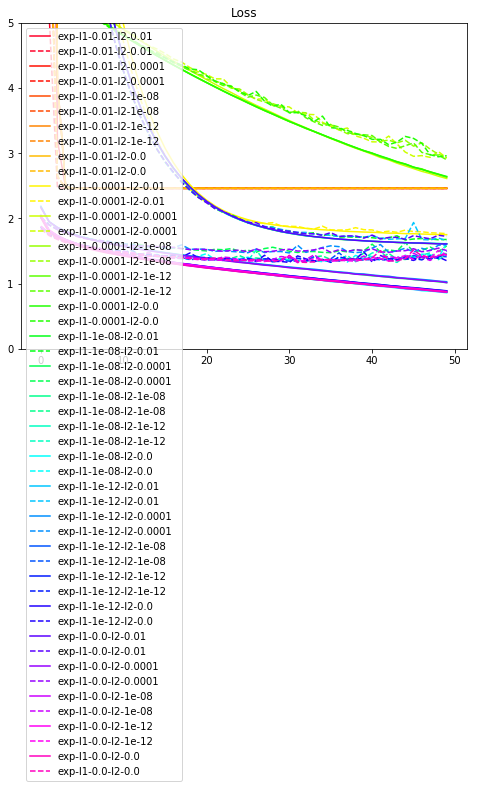

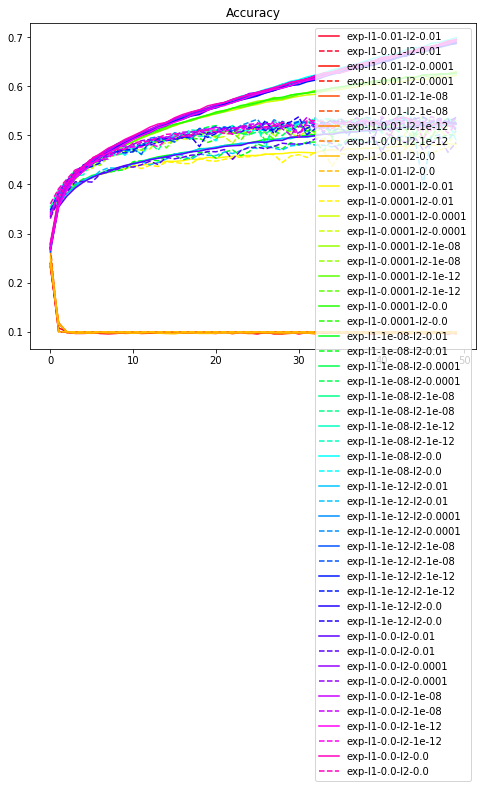

In [9]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
#color_bar = ["r", "g", "b", "y", "m", "k"]
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]


plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()